# Analyse: généralités

Tasks to be performed on flat runs:
* identify data path for run 13144
* display the 16 amplifiers of a sensor/raft
* overscan and bias correction
* gain correction
* display different illuminations

*******************

* Per set of data
    * Identify the biasses, and the level of illumination
* Per exposure / files / amps
   * open the file
   * correct for overscan and bias 
  
   

From P. Antilogus:
* /sps/lsst/users/antilog/web/bot/spot/Xtalk_Spot.ipynb
* bot_frame_op.py

From P. Astier:
* /sps/lsst/users/astier/slac/13144/gains.list 
* Cod.py

# NP (from P. Antilogus): Pour les données à differents flux : /sps/lsst/groups/FocalPlane/SLAC/run5/13144  c’est un run PTC
* le bas flux à des filtres neutres pour reduire le flux pour un temps de pose donnée … ci-joint la syntaxe des noms de directory :
  * flat_ND_OD0.5_SDSSi_492.0_flat0_351
      * ND_OD0.5: neutral density filter 0.5   ( l’autre solution : empty = pas de filtre )
      * SDSSi   : filtre SDSS i
      * 492.0   : flux de 492 e-   , le flux le plus bas est donné à 50e- …mais l’éclairement est non uniforme sur les bord c’est bien moins
      * flat0   : première pose d’une série de 2 ( il y aussi donc le flat1 )
      * 351     : 351 ieme pose du run
      # Analyse: généralités

Tasks to be performed on flat runs:
* identify data path for run 13144
* display the 16 amplifiers of a sensor/raft
* overscan and bias correction
* gain correction
* display different illuminations


In [1]:
import astropy.io.fits as pyfits
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import linregress
import json


%run -i  C:/Users/julie/OneDrive/Bureau/stage/bot_frame_op.py
    
dossier = 'CCD2'  #nom du dossier 
doss = os.listdir("C:/Users/julie/OneDrive/Bureau/stage/"+str(dossier))
data=(len(doss))



#ccd_exposure_1000=pyfits.open(file_name)

# Image plotting from P.A.
def plot_ccd_raw(ccd_exposure,contrast=250):
    h=list()
    for i in range(16):
        h.append(plt.hist(np.ravel(ccd_exposure[i+1].data),bins=100))

    #vmin=98000
    #vmax=102000
    window=contrast
    for i in range(16) :
    #    norm = ImageNormalize(fits[i+1].data[first_line:first_p_over,first_col:first_s_over], interval=PercentileInterval(70.))
        plt.subplot(2,8,i+1,title=i+1)
        #plt.imshow(fits[i+1].data[first_line:first_p_over,first_col:first_s_over],cmap = 'hot',origin='lower',norm=norm)

        center=(h[i][1][h[i][0].argmax()]+h[i][1][h[i][0].argmax()+1])/2
        vmin=center-window
        vmax=center+window

        plt.imshow(ccd_exposure[i+1].data,origin='lower',vmin=vmin,vmax=vmax)

        #print (np.mean(fits[i+1].data[first_line:first_p_over,first_col:first_s_over]) )
        if not(i%8 ==0) :
            figure=plt.gca()
            y_axis = figure.axes.get_yaxis()
            y_axis.set_visible(False)
        plt.colorbar()
    plt.show()
    
def parse_section(section_string) :
    # input : a fits-like section string (as in DATASEC '[y0:y1,x0:x1]')
    # output :  image section coordinate to be used in python table:  ymin , ymax ,xmin, xmax
    #
    r=section_string[1:-1].split(',')
    x=list(map(int,r[0].split(':')))
    y=list(map(int,r[1].split(':')))
    # put into pythonic way
    if y[0]<=y[1]:
        y[0] = y[0]-1
    else:
        y[1] = y[1]-1
    if x[0]<=x[1]:
        x[0] = x[0]-1
    else:
        x[1] = x[1]-1
    
    return y[0],y[1],x[0],x[1]

def SingleImageIR(actfile,gains=None):
        first_line,first_lover,first_col,first_cover=parse_section(actfile.Datasec[0])
        col_size=first_cover-first_col
        line_size=first_lover-first_line
        #
        spf=np.zeros((line_size*2,col_size*8))

        for i in range(16) :
            y1,y2,x1,x2=parse_section(actfile.Datasec[i])
            yd1,yd2,xd1,xd2=parse_section(actfile.Detsec[i])
            xdir,ydir=(1,1)
            if yd2<yd1:
                ydir=-1
                (yd2,yd1)=(yd1,yd2)
            if xd2<xd1:
                xdir=-1
                (xd2,xd1)=(xd1,xd2)
            if gains is not None:
                raft_ccd=actfile.raftbay+'_'+actfile.ccdslot
                amp='C'+actfile.Extname[i][-2:]
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir] * gains[raft_ccd][amp]
            else:
                spf[yd1:yd2,xd1:xd2]=actfile.Image[i][y1:y2,x1:x2][::ydir,::xdir]
        return spf
                
        for i in range(16) :
            if i<8 :
                xx=i*col_size-1
                yy=0
                for x in range(first_col,first_cover) : 
                    spf[yy:yy+line_size,xx+col_size-(x-first_col)]=actfile.Image[i][first_line:first_lover,x]
            else :
                xx=(15-i)*col_size
                yy=-1
                for y in range(first_line,first_lover) :  
                    spf[yy+2*line_size-(y-first_line),xx:xx+col_size]=actfile.Image[i][y,first_col:first_cover]
                    
        return spf
    
def show_image_contrasted(image_data,contrast='auto'):
    med=np.median(image_data)
    if contrast=='auto':
        contrast = 1.5 * stats.iqr(image_data)
    #plt.imshow(image_data,origin='lower',vmin=med-contrast,vmax=med+contrast)
    plt.colorbar()

In [19]:
def fit (diff_var,mean) :
    diff_var_=[]
    mean_=[]    
    sat = np.where(np.max(diff_var)== diff_var)
    for i in range (len(mean)):
        if  mean[i] < 5000:
            diff_var_.append(diff_var[i])
            mean_.append(mean[i])
    a, b, r, p_value, std_err = linregress(mean_, diff_var_)
    return (a,b,sat)
#sat = indice pour laquelle la diff de std est la plus grande

def fit_quadra (diff_var,mean,mean_max) :
    x_data=[]
    y_data=[]
    sat = np.where(np.max(diff_var)== diff_var)
    for i in range (len(mean)):
        if  mean[i] < mean_max:
            y_data.append(diff_var[i])
            x_data.append(mean[i])
    y_params = np.polyfit(x_data, y_data, 2)  #équation de degré 2
    y = np.poly1d(y_params)
    
    return y,y_params,sat

def fusion_fic (file,filenames):
    with open(file, 'w') as outfile:
        for names in filenames:
            with open(names) as infile:
                # read the data from file1,2 and 3
                # and write it in file
                outfile.write(infile.read())
            # Add '\n' to enter data of file2
            # from next line
            #outfile.write("\n")
    return 

def lecture (data,dossier):  #le dossier est à choisir au début du code 
    number=[]
    deo=[]
    tab=np.zeros((int(data/2),35))
    listenum = np.zeros(data)

    for p in range (16) :  #dans la liste des fichiers (des illuminations)
        count=0
        for nb in range (data):
            file_name = 'C:/Users/julie/OneDrive/Bureau/stage/' + str(dossier) +'/' + str (doss[nb]) #nom du fichier 
            ccd_exposure_1000=pyfits.open(file_name) #recup les données
            num=file_name.split('_') #numéro du fichier ouvert
            listenum[nb]=num[3]
            file_list=[file_name]  #fait liste des fichiers
            FileUnBias=InFile(dirall=file_list,Slow=False,verbose=False,Bias=UnBias) 
            deoverscanned=SingleImageIR(FileUnBias.all_file[0])  #assemble les données corriger d'overscan en 1 image

          #On recupère les données pour chaque amplis
            if p == 1 :
                tab[count,33]=np.mean((deoverscanned+deo_CCD)/2)
                tab[count,34]=np.std(deoverscanned-deo_CCD)
                
            if p <=7:
                ampli=deoverscanned[0:2002,512*(p):(513)*(p+1)]
            else :
                ampli=deoverscanned[2002:-1,512*(p-8):(513)*(p+1-8)]

            #une fois que j'ai les données pour un ampli je recupère dans un tableau le numéro, la différence du signal et la moyenne

            if float(listenum[nb]) == float(listenum[nb-1])+1 :
                tab[count,0]=(num[3])
                tab[count,p+1]= np.std(deo-ampli) #met les données de diff std (col 1:16)
                tab[count,p+17]= np.mean((deo+ampli)/2) #met la moyenne des ampli col  (17:33) 
                count +=1
            elif nb> 1 and float(listenum[nb-1])!= float(listenum[nb-2])+1 and float(listenum[nb]) == float(listenum[nb-1])+2 :
                tab[count,0]=(num[3])
                tab[count,p+1]= np.std(deo-ampli) #met les données de diff std (col 1:16)
                tab[count,p+17]= np.mean((deo+ampli)/2) #met la moyenne des ampli col  (17:33) 
                count +=1
            deo=ampli
            deo_CCD = deoverscanned
            
    return tab
        
        
# Sauvegarder le tableau dans un fichier texte
#col 0 : numéro du fichier
#col 1 à 16 : valeur de différences de std entre les deux flats pour chaque amplis
#col 17 à 32 : valeur de la moyenne pour chaque amplis
#col 33 : moyenne de la CCD
#col 34 : std de la différence des flats


In [20]:
UnBias='1D'
#UnBias='2D'

In [21]:
#enregistre les données des moyennes et std (très long)
#tab = lecture(data, dossier)
#np.savetxt("tab_" +str (dossier )+'_'+str(UnBias)+".txt", tab)  #donne un nom comme :'tab_CCD_1D.txt'

In [22]:
#fusionner les fichiers des CCD si les données dans plusieurs dossiers et si nécessaire
#filenames = ['tab_CCD_'+str(UnBias)+'.txt', 'tab_CCD1_'+str(UnBias)+'.txt' ,'tab_CCD2_'+str(UnBias)+'.txt']
#filenames=['mean_deoverscanned_gain.txt','mean_deoverscanned_gain_1.txt','mean_deoverscanned_gain_2.txt']
#file='deoverscanned_flat_'+str(UnBias)+'.txt'
#fusion_fic(file,filenames)  #fichier de sortie de la forme : 'deoverscanned_flat_1D.txt'

In [39]:
def plot_ampli (file_name):
    tab = np.genfromtxt(file_name, delimiter=' ') #lit les donner du fichier et transforme en tableau numpy       
    fig, axs = plt.subplots(4,4,sharex=True,figsize=(18,9))
    i=0
    l=np.linspace(0,mean_max,1000)
    for ax in axs.flat:

        a_ampli,b_ampli,sat_ampli=fit((tab[:,i+1]**2)/2,tab[:,i+17]) 
        y,y_params,sat=fit_quadra(((tab[:,i+1]**2)/2)-b_ampli,tab[:,i+17],mean_max)

        ax.plot(tab[:,i+17],(((tab[:,i+1]**2)/2)),'.') 
        ax.plot(l,y(l))
        ax.label_outer()

        #affiche la légende
        ax.text(mean_max/2,100, "HDU {:} \nGain = {:.2f}\nTurnoff = {:.4f}  ".format(i+1,1/y_params[1],  tab[sat[0],i+17][0]), fontsize=12)
        
      
        i=i+1
        
        #limites des axes 
        #ax.set_xlim(0,mean_max)
        #ax.set_ylim(0,35000)
        
    #légende commune 
    fig.suptitle('PTC for R22-S11-run13144 : 84 illuminations (unbias 1D)')
    fig.supxlabel('mean signal (ADU)')
    fig.supylabel('var ($ADU^{2}$)')

    fig.tight_layout()
    plt.savefig('PTC')
    return

def plot_CCD (file_name):
    tab = np.genfromtxt(file_name, delimiter=' ')
    plt.figure()
    l=np.linspace(0,mean_max,1000)
    
    a_ampli,b_ampli,sat_ampli=fit((tab[:,14]**2)/2,tab[:,30]) 
    y,y_params,sat=fit_quadra(((tab[:,14]**2)/2)-b_ampli,tab[:,30],mean_max)
    
    plt.plot(tab[:,30],(tab[:,14]**2)/2,'.b')
    print(1/a_ampli)
    plt.plot(l,a_ampli*l+b_ampli,'g')
    plt.plot(l,y(l),color="darkorange")
    
    plt.xlabel("mean signal (ADU)")
    plt.ylabel("variance ($ADU^{2}$) ")
    plt.text(mean_max/2,100, "HDU {:} \nGain = {:.2f}\nTurnoff = {:.4f}  ".format(14,1/y_params[1],  tab[sat[0],30][0]), fontsize=12)
    plt.title('PTC for R22-S11-run13144 : 84 illuminations')
    
    #limite et échelle des axes
    #plt.xlim(0,mean_max)
    #plt.ylim(0,10000)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.savefig('ptchdu14')
    plt.show()
    return

1.4251480956155995


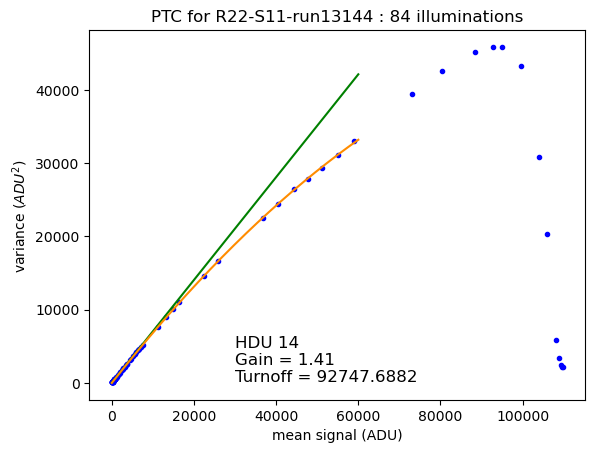

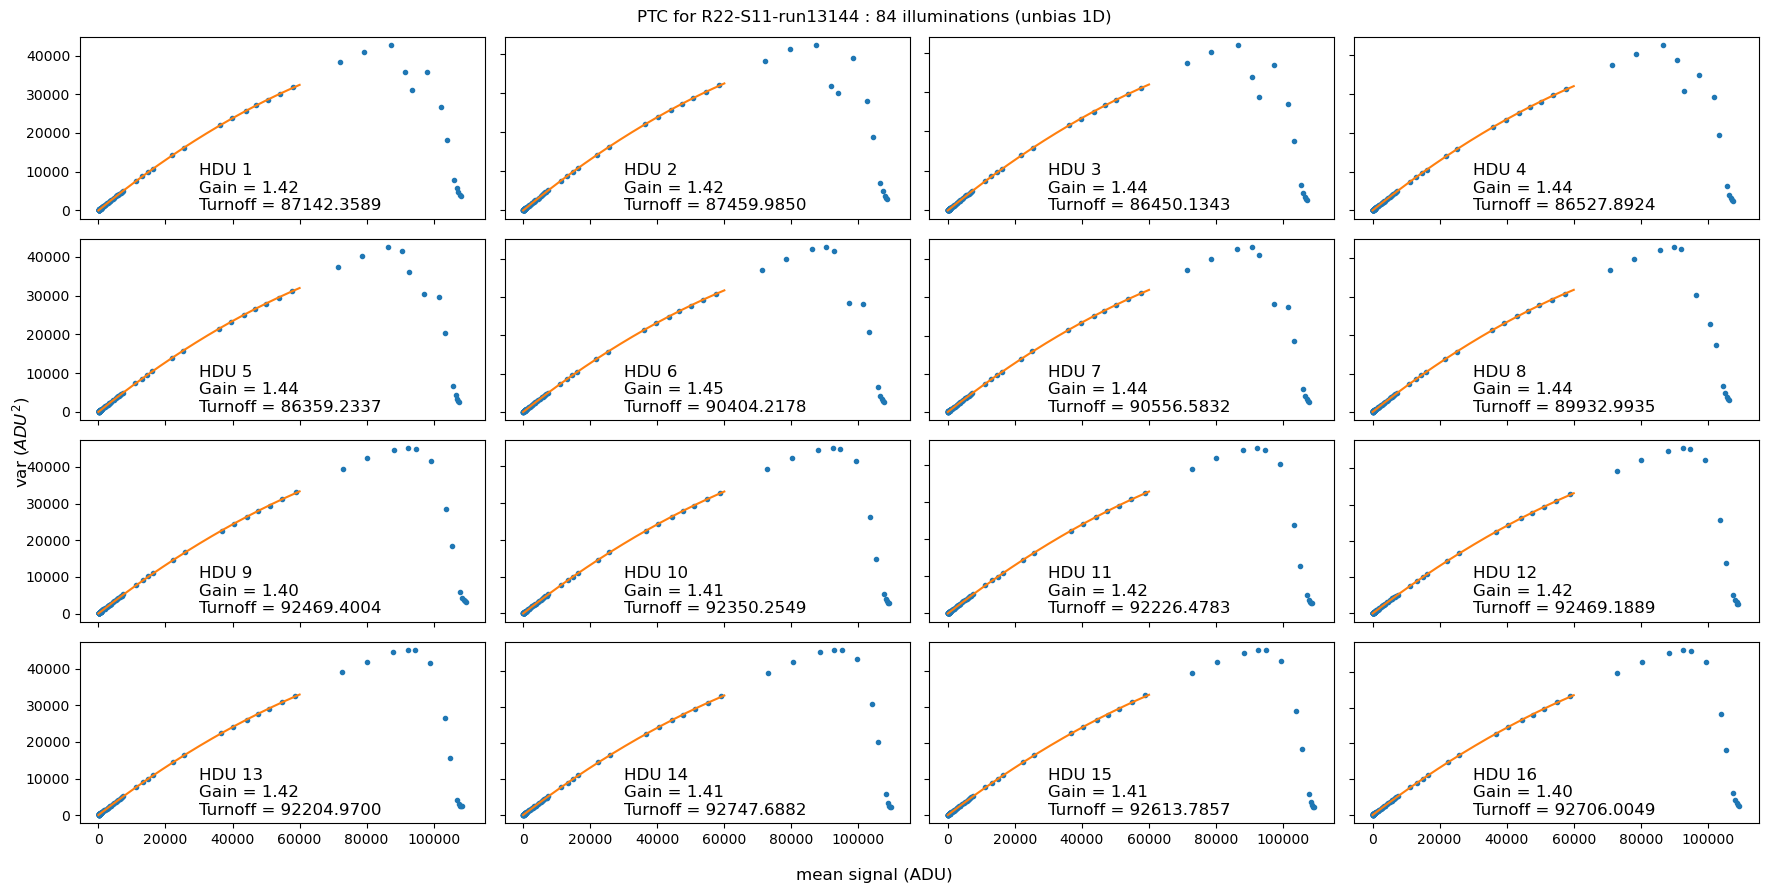

In [40]:
file_name = "deoverscanned_flat_1D.txt"
mean_max = 60000  #valeur maximale pour faire le fit
plot_CCD(file_name)
plot_ampli(file_name)

In [8]:
plt.figure(1)
plt.plot(mean,((diff_var))/mean,'.r')

#plt.plot(mean,a*mean+b)
l=np.linspace(0,mean_max,1000)
#plt.plot(l,y(l))
plt.xlabel("mean signal (ADU)")
#plt.xlim(0,20000)
#plt.ylim(0,10000)
plt.ylabel("variance ($ADU^{2}$) /mean")
#plt.text(mean_max/2, 1000,"Gain = {:.4f}\nSaturation = {:.4f} ".format(1/y_params[1], mean[sat[0]][0]), fontsize=12)
#plt.yscale('log')
#plt.xscale('log')

plt.show()

NameError: name 'mean' is not defined

<Figure size 640x480 with 0 Axes>